# Blackjack with Gym

using gym play blackjack with a much streamlined algo for monte carlo

# prediction task

In [1]:
import gym
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
env = gym.make('Blackjack-v1')

In [3]:
print(env.reset())

((17, 9, False), {})


In [4]:
print(env.step(1))
#state, reward, done, info, trunc

#state = (player, dealer, ace)

((18, 9, False), 0.0, False, False, {})


In [5]:
#naive policy to hit until 19
def policy(state):
    return 0 if state[0] > 19 else 1


In [6]:
def generate_episode(policy, env):
    episode = []
    state = env.reset()[0]
    done = 0
    
    while not done:
        action = policy(state)
        
        next_state, reward, done, info, trunc = env.step(action)
        
        episode.append((state, action, reward))
        
        state = next_state
        
    return episode

In [7]:
def value_assessment(policy, env, num_iterations = 500000, gamma = 0.99, every_visit = 0):
    total_return = defaultdict(float)
    N = defaultdict(int)
    for i in range(num_iterations):
        visited_states = []
        episode = generate_episode(policy, env)
        states, action, rewards = zip(*episode)
        for t, state in enumerate(states):
            R = (sum(rewards[t:]))
            if not every_visit:
                if state in visited_states:
                    continue                    
            visited_states.append(state)
            total_return[state] += (gamma * R)
            N[state] += 1


    total_return = pd.DataFrame(total_return.items(),columns=['state','total_return'])
    N = pd.DataFrame(N.items(),columns=['state', 'N'])
    df = pd.merge(total_return, N, on="state")
    df['value'] = df['total_return']/df['N']
    
    return df

In [8]:
#plot
def plot_heat(df, ace = 0):
    value_map_no_ace = np.zeros((22,22))

    for index, row in df.iterrows():
        if ace:
            if not row[0][2]:
                value_map_no_ace[row[0][0],row[0][1]] = row[3]
        else:
            if row[0][2]:
                value_map_no_ace[row[0][0],row[0][1]] = row[3]

    plt.imshow(value_map_no_ace, cmap='hot', interpolation='nearest')
    plt.axis([1,21,1,21])
    plt.ylabel('dealer show')
    plt.xlabel('player hand')
    plt.show()


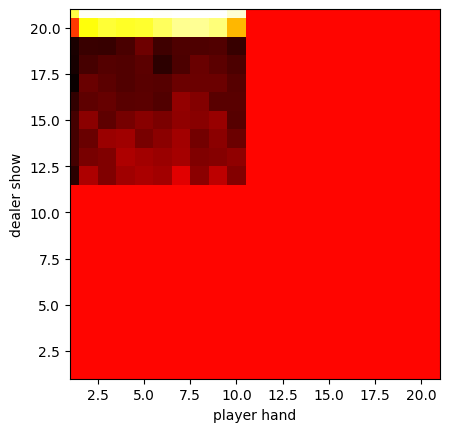

In [9]:
mc_df = value_assessment(policy = policy, env = env, num_iterations = 500000, gamma = 0.99, every_visit = 0)

plot_heat(mc_df, ace = 0)

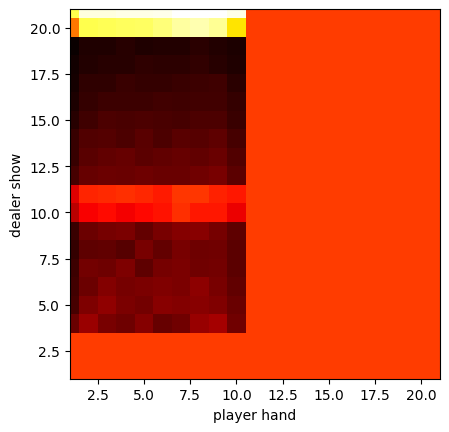

In [10]:
plot_heat(mc_df, ace = 1)

# control task

In [11]:
def epsilon_greedy_policy(state, epsilon, env, q):
    if np.random.uniform(0,1) < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax([q[tuple((state, 0))], q[tuple((state, 1))]])

In [12]:
def generate_episode(policy, epsilon, env, q):
    episode = []
    state = env.reset()[0]
    done = 0
    
    while not done:
        action = policy(state, epsilon, env, q)
        
        next_state, reward, done, info, trunc = env.step(action)
        
        episode.append((state, action, reward))
        
        state = next_state
        
    return episode

In [13]:
def control_assessment(policy, env, num_iterations = 500000, gamma = 0.99, every_visit = 0, epsilon = .10):
    total_return = defaultdict(float)
    N = defaultdict(int)
    q = defaultdict(float)
    for i in range(num_iterations):
        visited_states = []
        episode = generate_episode(policy, epsilon, env, q)
        states, actions, rewards = zip(*episode)
        for t in range(len(states)):
            state = states[t]
            action = actions[t]
            state = tuple((state, action))
            R = (sum(rewards[t:]))
            if not every_visit:
                if state in visited_states:
                    continue                    
            visited_states.append(state)
            total_return[state] += (gamma * R)
            N[state] += 1
            q[state] = total_return[state]/N[state]
           
    df = pd.DataFrame(q.items(),columns=['state_action pair','value'])
    
    return q, df

In [14]:
q, df = control_assessment(epsilon_greedy_policy, env, num_iterations = 500000, gamma = 0.99, every_visit = 0)

df

,state_action pair,value
0,"((14, 1, False), 0)",-0.734516
1,"((14, 1, False), 1)",-0.602420
2,"((15, 7, False), 0)",-0.444135
3,"((15, 7, False), 1)",-0.411934
4,"((15, 10, False), 0)",-0.593156
...,...,...
555,"((17, 2, True), 0)",-0.033559
556,"((17, 2, True), 1)",-0.024231
557,"((4, 8, False), 1)",-0.210000
558,"((4, 7, False), 0)",-0.541698


sanity check below if we stick with 21 we should see a higher q value than if we hit

In [17]:
df[df['state_action pair'] == ((21,1, False), 0)]

,state_action pair,value
140,"((21, 1, False), 0)",0.631226


In [18]:
df[df['state_action pair'] == ((21,1, False), 1)]

,state_action pair,value
141,"((21, 1, False), 1)",-0.99
